# MNIST - Spiking neural network with spike timing dependent plasticity

The purpose of this work is to demonstrate local learning rules (STDP) whit the MNIST handwritten digit classification problem. The main ideas are taken from the article [Unsupervised learning of digit recognition using spike-timing-dependent plasticity](https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full), but the experiment was reconstructed with significant changes from the original work.

## Spiking neural network architecture

To model neuron dynamics leaky integrate-and-fire model is used. Synapses are modeled by conductance changes, i.e., synapses increase their conductance instantaneously by the synaptic weight when a presynaptic spike arrives at the synapse, otherwise the conductance is decaying exponentially.

The network consists of two layers. The first layer is the input layer, containing 28 × 28 neurons (one neuron per image pixel), and the second layer is the processing layer, containing 100 excitatory neurons and 100 inhibitory neurons. Each input is a Poisson spike-train, which is fed to the excitatory neurons of the second layer for the 350 ms following by 150 ms resting period. The rates of each neuron are proportional (devided by 4) to the intensity of the corresponding pixel in the example image.

The excitatory neurons of the second layer are connected in a one-to-one fashion to inhibitory neurons, i.e., each spike in an excitatory neuron will trigger a spike in its corresponding inhibitory neuron. Each of the inhibitory neurons is connected to all excitatory ones, except for the one from which it receives a connection. This connectivity provides lateral inhibition and leads to competition among excitatory neurons. All synapses from input neurons to excitatory neurons are learned using STDP. The weights of the remaining synapses are fixed.

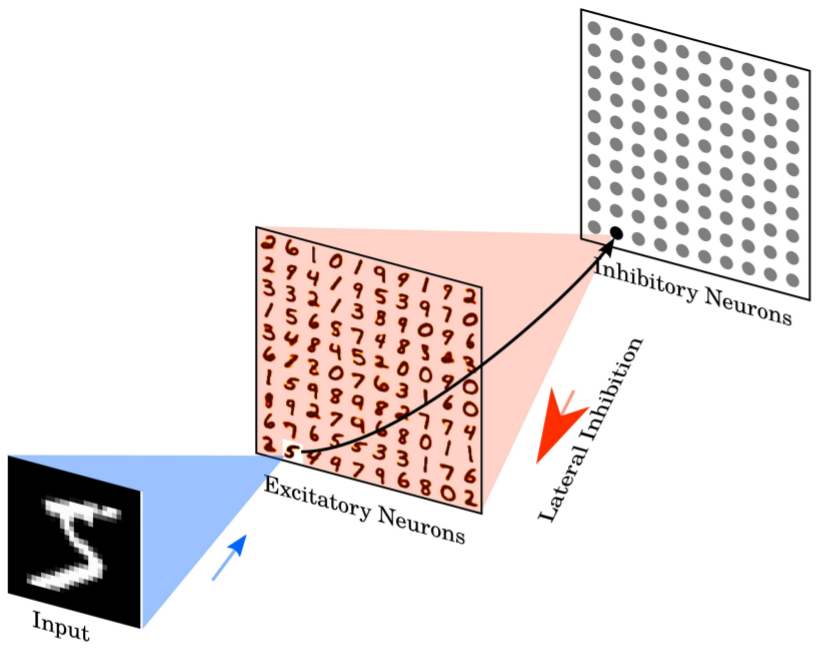

To understand this part I recomend [https://www.coursera.org/learn/synapses/](https://www.coursera.org/learn/synapses/)

## Experiment design and observed results

1. Feed train set to SNN described above
2. Freeze STDP
3. Feed train set to SNN again and collect generated features (spike counts foreach excitatory neuron during single image representation)
4. Train RandomForest on the top of these features and labels provided
5. Feed test set to SNN and collect new features
6. Predict labels with RandomForest and calculate accuacy score

It reaches 0.9 accuracy on the test set with only 5k training examples and 3 classes. In order to understand whether local learning affects the result, the experiment was repeated but without training SNN with STDP. Second experiment scored 0.74, which clearly shows the efficiency of local training.

In [157]:
from keras.datasets import mnist
from brian2 import *
import brian2.numpy_ as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [158]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# simplified classification (0 1 and 8)
X_train = X_train[(y_train == 1) | (y_train == 0) | (y_train == 8)]
y_train = y_train[(y_train == 1) | (y_train == 0) | (y_train == 8)]
X_test = X_test[(y_test == 1) | (y_test == 0) | (y_test == 8)]
y_test = y_test[(y_test == 1) | (y_test == 0) | (y_test == 8)]

# pixel intensity to Hz (255 becoms ~63Hz)
X_train = X_train / 4 
X_test = X_test / 4

X_train.shape, X_test.shape

((18516, 28, 28), (3089, 28, 28))

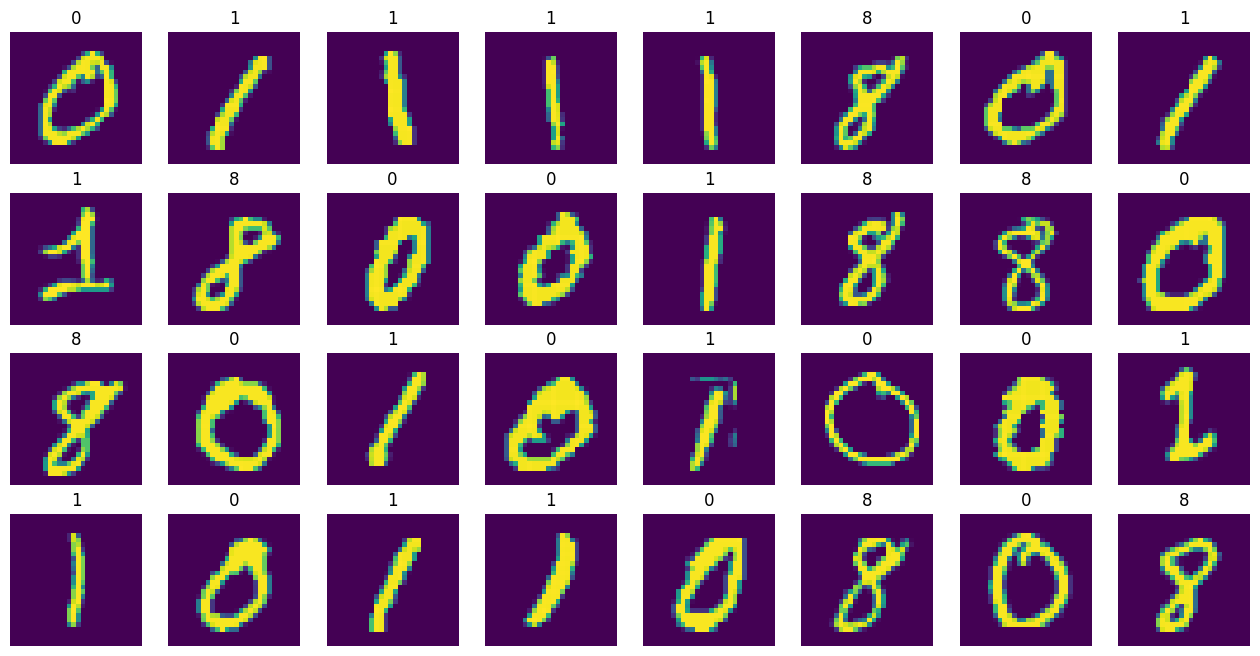

In [159]:
plt.figure(figsize=(16,8))
for img in range(32):
    plt.subplot(4,8,1+img)
    plt.title(y_train[img])
    plt.imshow(X_train[img])
    plt.axis('off')

In [160]:
n_input = 28*28 # input layer
n_e = 2 # e - excitatory

v_rest_e = -60.*mV # v - membrane potential
v_reset_e = -65.*mV
v_thresh_e = -52.*mV

last_int_ind = 0
last_output_ind = 0 

taupre = 20*ms
taupost = taupre
gmax = .05 #.01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax 
dApre *= gmax 

# Apre and Apost - presynaptic and postsynaptic traces, lr - learning rate
rstdp='''w : 1
    reward : 1
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''
pre='''ge += w
    Apre += dApre
    w = clip(w + reward*Apost, 0, gmax)'''
post='''Apost += dApost
    w = clip(w + reward*Apre, 0, gmax)'''

class Model():
    
    def __init__(self, debug=False):
        app = {}
                
        # input images as rate encoded Poisson generators
        app['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='PG')
        
        # excitatory group
        neuron_e = '''
            dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            dgi/dt = -gi / (10*ms) : 1
            '''
        app['EG'] = NeuronGroup(n_e, neuron_e, threshold='v>v_thresh_e', refractory=5*ms, reset='v=v_reset_e', method='euler', name='EG')
        app['EG'].v = v_rest_e - 20.*mV
        app['ESP'] = SpikeMonitor(app['EG'], name='ESP')
        app['PSP'] = SpikeMonitor(app['PG'], name='PSP')
        
        if (debug):
            app['ESM'] = StateMonitor(app['EG'], ['v'], record=True, name='ESM')
            app['ERM'] = PopulationRateMonitor(app['EG'], name='ERM')
            app['PRM'] = PopulationRateMonitor(app['PG'], name='PRM')
        

        # poisson generators one-to-all excitatory neurons with plastic connections 
        app['S1'] = Synapses(app['PG'], app['EG'], rstdp, on_pre=pre, on_post=post, method='euler', name='S1')
        app['S1'].connect()
        app['S1'].w = 'rand()*gmax' # random weights initialisation
        app['S1'].reward = 'rand()' # enable stdp        
        
        if (debug):
            # some synapses
            app['S1M'] = StateMonitor(app['S1'], ['w', 'Apre', 'Apost', 'reward'], record=app['S1'][380,:4], name='S1M') 
            app['S1M_prim'] = StateMonitor(app['S1'], ['w'], record=True, name='S1M_prim') 

        
        self.net = Network(app.values())
        self.net.run(0*second)
        
    def __getitem__(self, key):
        return self.net[key]
    
    def calculate_sttc(self, t1, t2, dt, total_time):
        """
        Calculate the Spike-Time Tiling Coefficient (STTC) between two spike trains.

        Parameters:
        - t1, t2: Arrays of spike times for the two neurons.
        - dt: The time window (\Delta t) for considering spikes coincident (in the same time unit as t1 and t2).
        - total_time: The total duration of the experiment/simulation.

        Returns:
        - STTC value
        """

        # Convert to numpy arrays for efficiency
        t1, t2 = np.array(t1), np.array(t2)
        
        # Define a function to calculate PA or PB
        def fraction_spike_pairs(ti, tj):
            count = 0
            for spike in tj:
                for spike_i in ti:
                    difference = abs(spike - spike_i)
                    if difference <= dt:
                        count += 1
            if (len(ti) != 0):
                return count/len(ti)
            else:
                return 0

         # Define a function to calculate TA or TB
        def fraction_time_pairs(ti, tj):
            expanded_tj = np.concatenate(([tj-dt], [tj+dt])).T.flatten()
            expanded_tj.sort()
            # Ensure time windows don't overlap total time
            valid_times = np.clip(expanded_tj, 0, total_time)
            duration = np.sum(np.diff(valid_times)[::2])
            return duration / total_time

        PA = fraction_spike_pairs(t1, t2)
        PB = fraction_spike_pairs(t2, t1)
        # TA = fraction_time_pairs(t1, t2)
        # TB = fraction_time_pairs(t2, t1)
        TA = len(t1)
        TB = len(t2)

        # Calculate the STTC
        #sttc = 0.5 * ((PA - NA / total_time) / (1 - NA / total_time) + (PB - NB / total_time) / (1 - NB / total_time))
        sttc_value = 0.5 * ((PA - TA) / (1 - PA * TA) + (PB - TB) / (1 - PB * TB))
        #rw = (sttc_value + 1) / 2 * (1.0 - 0) + 0
        return sttc_value / 10

    def train(self, X, epoch=1):        
        self.net['S1'].reward = 1 # stdp on
        
        for ep in range(epoch):
            for idx in range(len(X)):
                # active mode
                self.net['PG'].rates = X[idx].ravel()*Hz
                
                idk = self.calculate_sttc(self.net['PSP'].t * 1000, self.net['ESP'].t, 1, 3500*(idx+1))
                print(idk)
                # rw = self.calculate_pairwise_resemblance(1*ms, 3500*(idx+1))
                # rw = np.array(rw)
                self.net['S1'].reward = idk
                self.net.run(0.35*second)
 
                # passive mode
                self.net['PG'].rates = np.zeros(n_input)*Hz
                self.net.run(0.15*second)
        


    def evaluate(self, X):       
        self.net['S1'].reward = 0  # stdp off
        
        features = []
        for idx in range(len(X)):
            # rate monitor to count spikes
            mon = SpikeMonitor(self.net['EG'], name='RM')
            self.net.add(mon)
            
            # active mode
            
            self.net['PG'].rates = X[idx].ravel()*Hz


            
            idk = self.calculate_sttc(self.net['PSP'].t * 1000, self.net['ESP'].t, 1, 3500*(idx+1))
            #print(idk)
            # rw = self.calculate_pairwise_resemblance(1*ms, 3500*(idx+1))
            # rw = np.array(rw)
            self.net['S1'].reward = idk
            self.net.run(0.35*second)
            # spikes per neuron foreach image
            features.append(np.array(mon.count, dtype=int8))
            
            # passive mode
            self.net['PG'].rates = np.zeros(n_input)*Hz
            self.net.run(0.15*second)
            
            self.net.remove(self.net['RM'])
            
        return features

0.0
0.3106630549979156
0.30136256666165856
0.30514303350530547
0.3180363609360587
0.32697876724939734
0.3268847507050789
0.3346178447004671
0.34105449118068365
0.35325103063676744
0.35760942704875315
0.34202788469590995
0.3310635090929777
0.32875163386722406
0.3158368783242966
0.3092383193675584
0.29124040366133347
0.2845076357530365
0.2875565901880765
0.2884977424411538
0.2912361463052548
0.2938579629002641
0.2946448960602267
0.2918063280112914
0.29057544945430286
0.2890338175765591
0.28152800495213226
0.28156648563889836
0.28035374524710505
0.2769593954115952


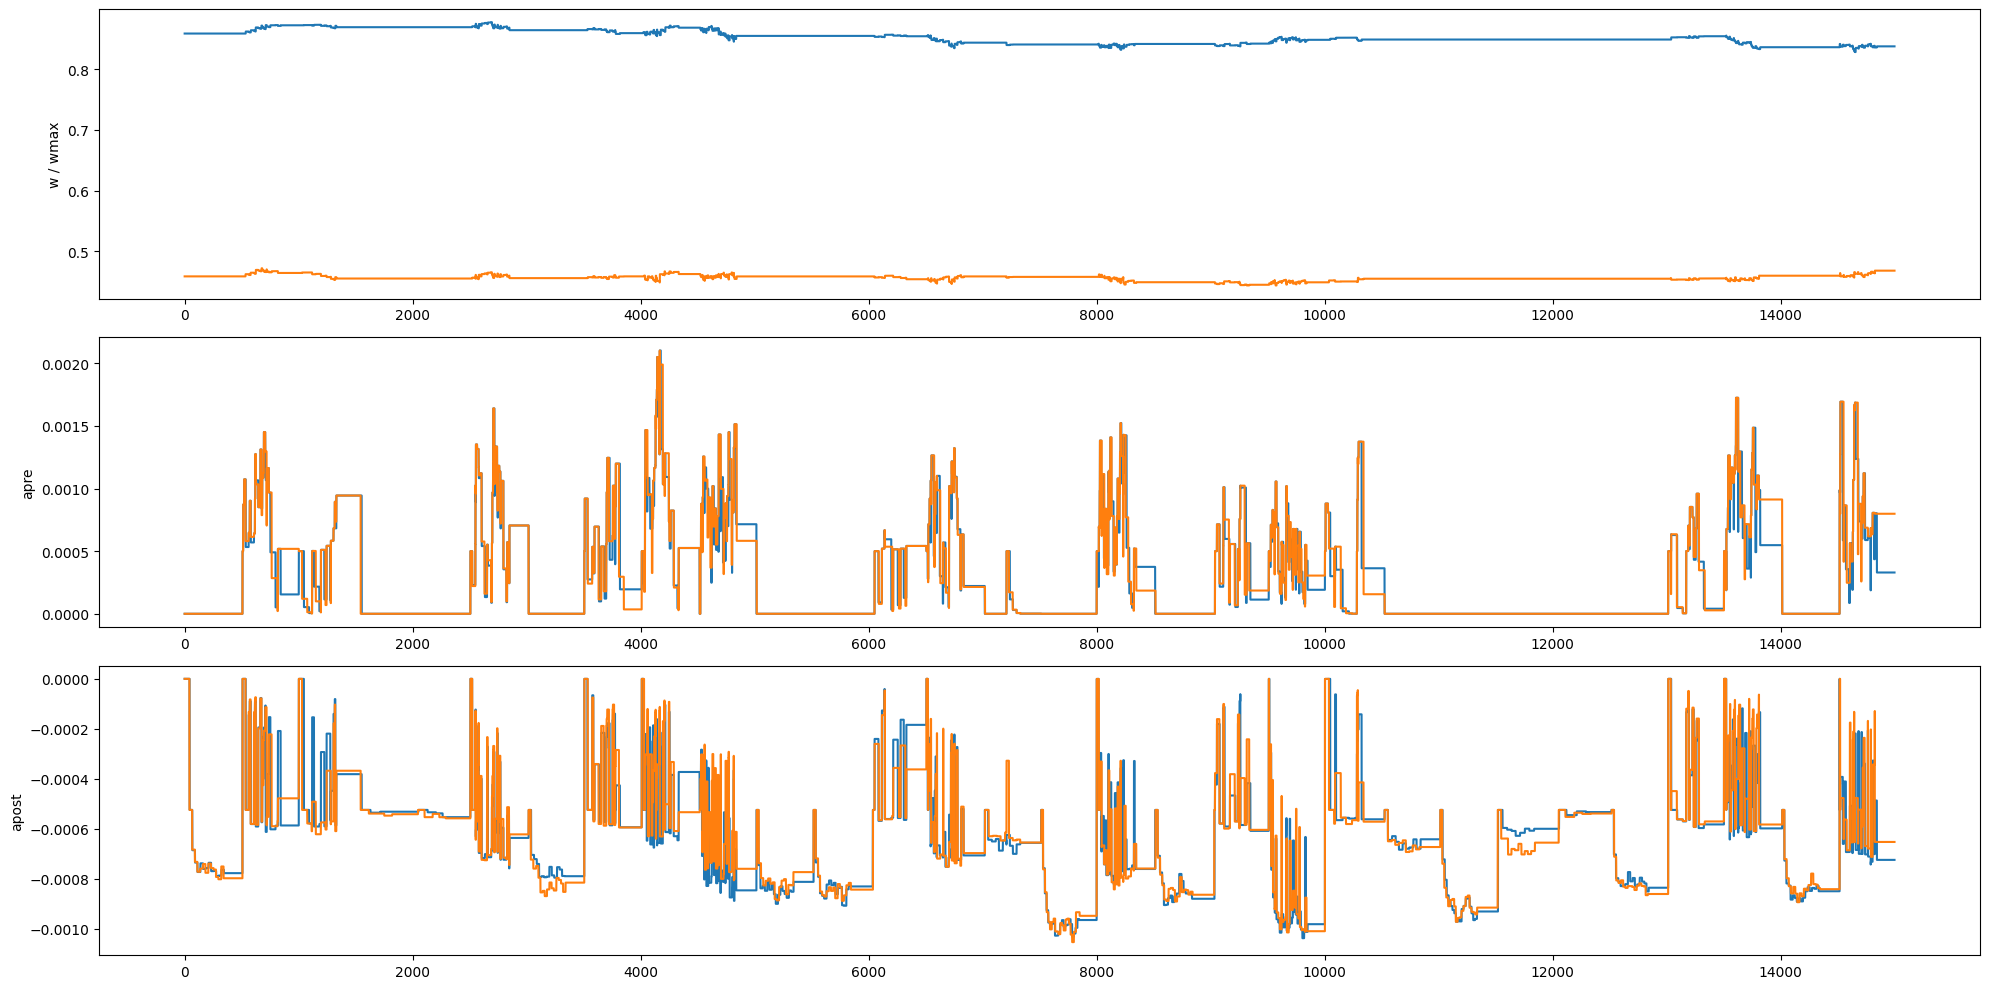

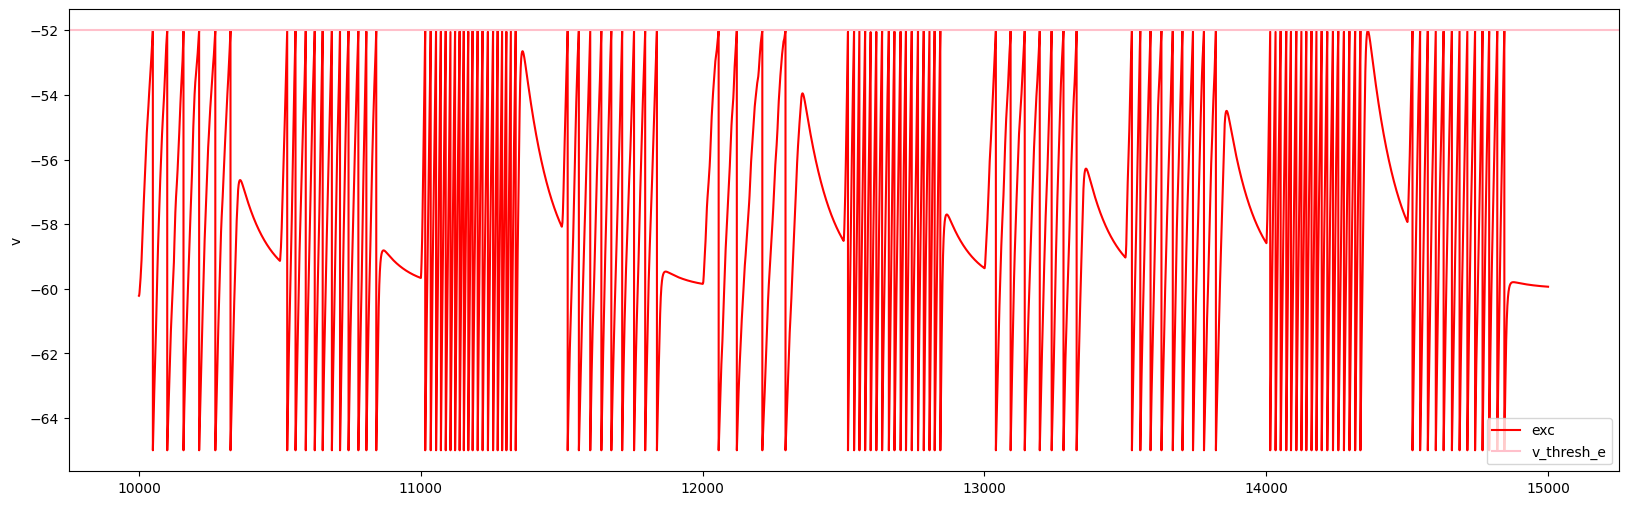

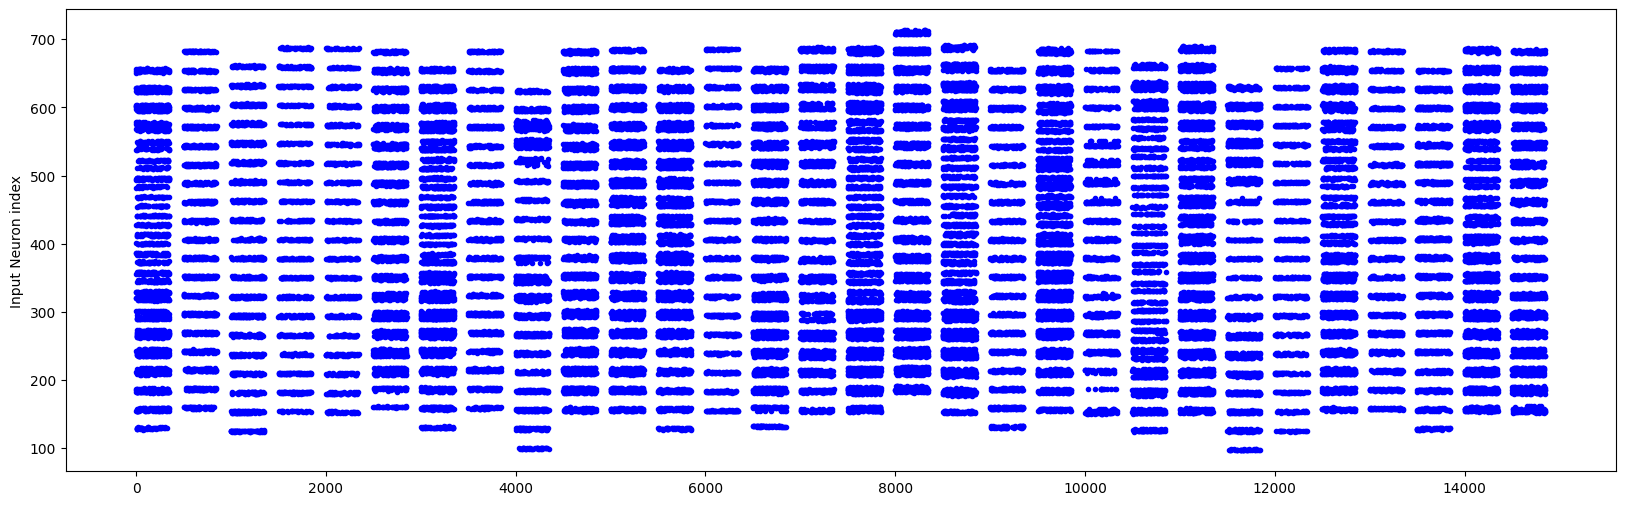

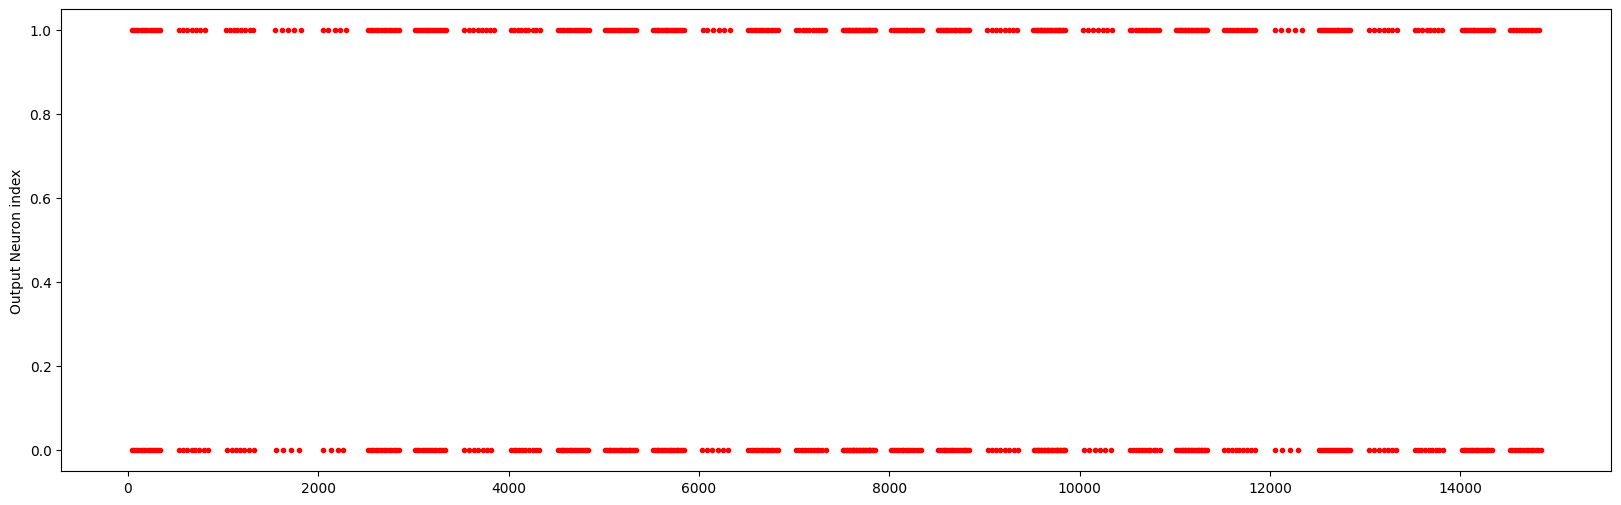

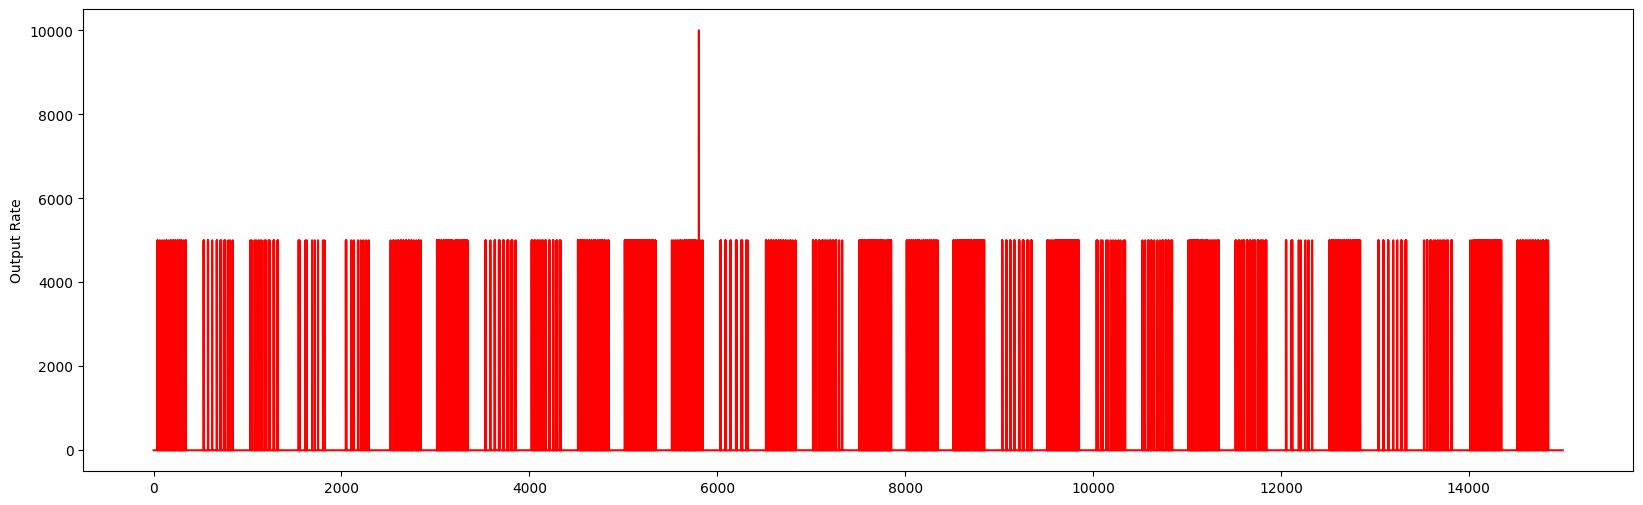

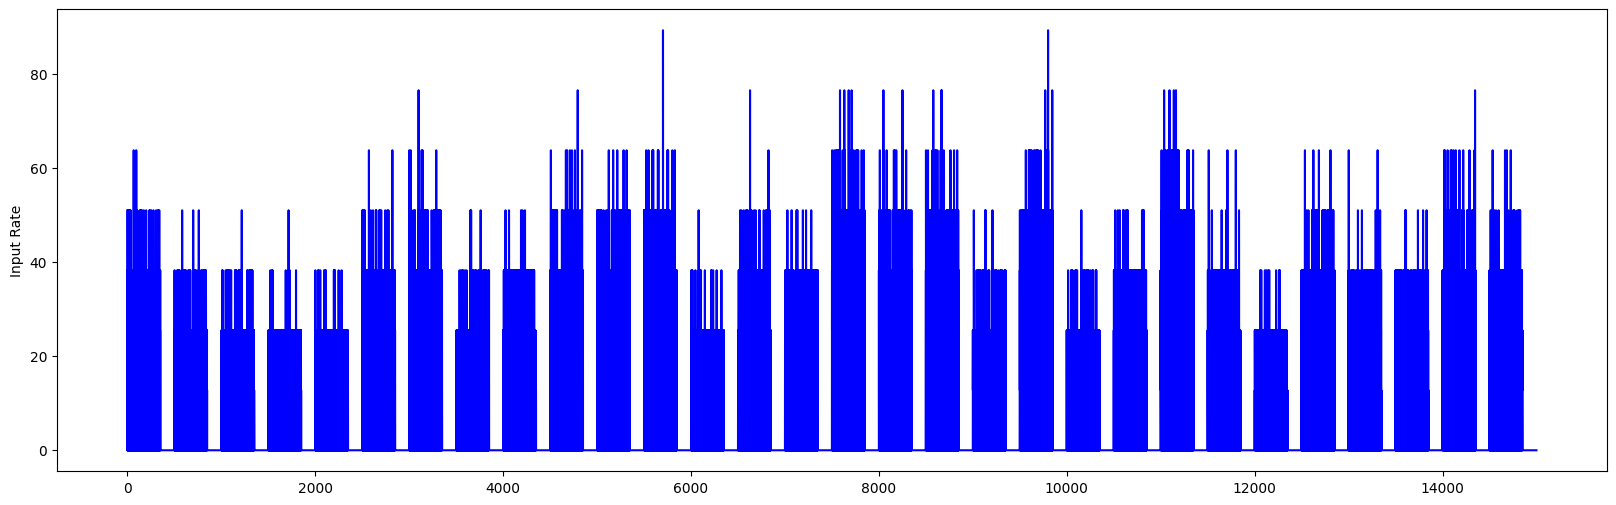

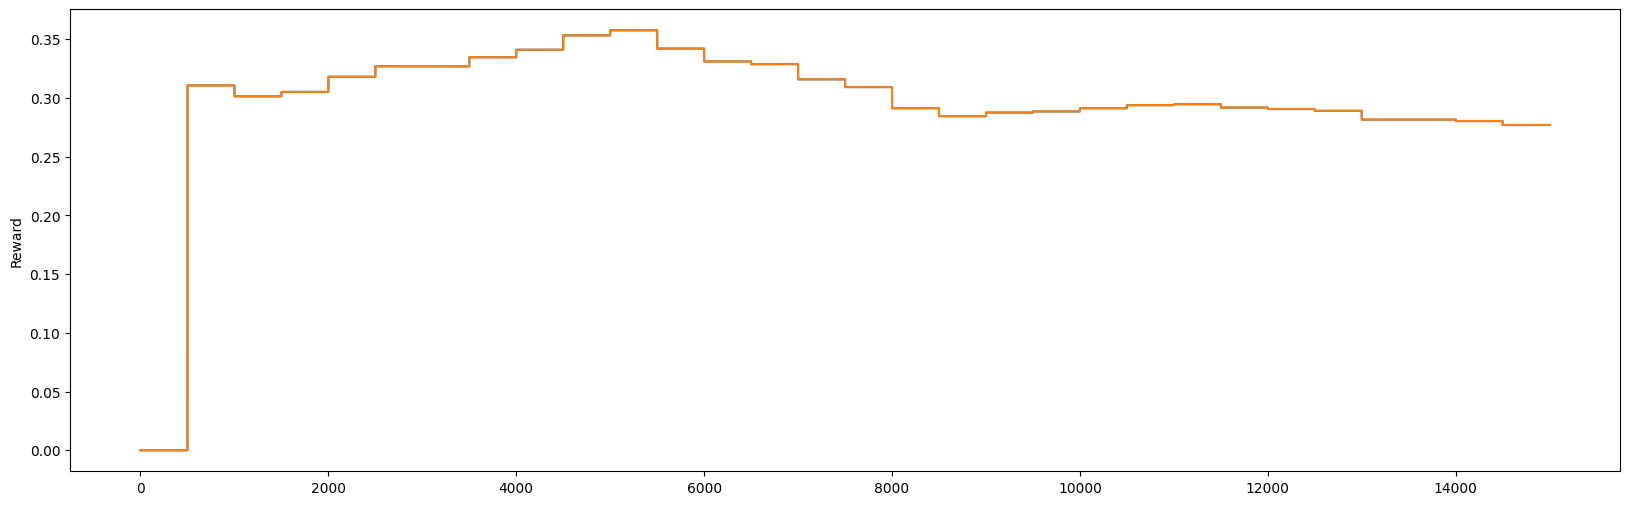

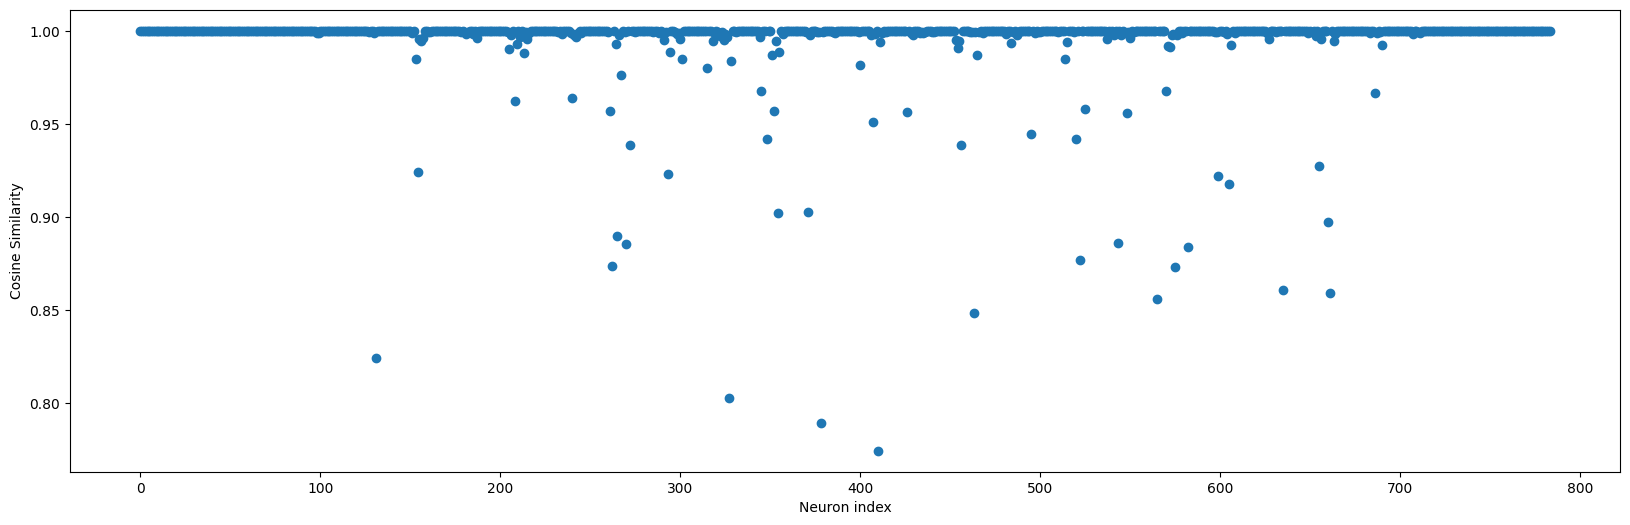

In [161]:
def plot_w(S1M):
    plt.rcParams["figure.figsize"] = (20,10)
    subplot(311)
    plot(S1M.t/ms, S1M.w.T/gmax)
    ylabel('w / wmax')
    subplot(312)
    plot(S1M.t/ms, S1M.Apre.T)
    ylabel('apre')
    subplot(313)
    plot(S1M.t/ms, S1M.Apost.T)
    ylabel('apost')
    tight_layout()
    show();
    
def plot_v(ESM, neuron=0):
    plt.rcParams["figure.figsize"] = (20,6)
    cnt = -50000 # tail
    plot(ESM.t[cnt:]/ms, ESM.v[neuron][cnt:]/mV, label='exc', color='r')
    plt.axhline(y=v_thresh_e/mV, color='pink', label='v_thresh_e')
    legend()
    ylabel('v')
    show();
    
def plot_rates_output(ERM):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ERM.t/ms, ERM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='r')
    ylabel('Output Rate')
    show();

def plot_rates_input(PRM):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(PRM.t/ms, PRM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='b')
    ylabel('Input Rate')
    show();
    
def plot_spikes_inp(PSP):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(PSP.t/ms, PSP.i, '.b')
    ylabel('Input Neuron index')
    show();

def plot_spikes_out(ESP):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ESP.t/ms, ESP.i, '.r')
    ylabel('Output Neuron index')
    show();

def plot_cos_similarity(M):
    def calculate_cosine_similarities(weights):
        cos_similarities = []  # Assuming you want to compare in pairs, hence dividing by 2
        N = M.w.shape[0] // 2
        for i in range(N):
            vec1 = weights[2*i]
            vec2 = weights[2*i + 1]
            
            # Calculate norms
            norm1 = np.linalg.norm(vec1)
            norm2 = np.linalg.norm(vec2)
            
            # Ensure norms are not zero to avoid division by zero
            if norm1 > 0 and norm2 > 0:
                cos_sim = np.dot(vec1, vec2) / (norm1 * norm2)
            else:
                cos_sim = 0  # Assigning a default value in case of zero division
            
            cos_similarities.append(cos_sim)
        
        return cos_similarities

    cos_similarities = calculate_cosine_similarities(M.w)
    plt.rcParams["figure.figsize"] = (20,6)
    plt.scatter(range(len(cos_similarities)), cos_similarities)
    plt.ylabel('Cosine Similarity')
    plt.xlabel('Neuron index')
    plt.show()

def plot_w_dist(S):
    plt.hist(S.w[:], bins=50)
    plt.title('Distribution of synaptic weights after STDP')
    plt.xlabel('Weight')
    plt.ylabel('Count')
    plt.show()

def plot_reward(S1M):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(S1M.t/ms, S1M.reward.T)
    ylabel('Reward')
    show();

def test0(train_items=30):
    '''
    STDP visualisation
    '''
    seed(0)
    
    model = Model(debug=True)
    model.train(X_train[:train_items], epoch=1)
    

    plot_w(model['S1M'])
    plot_v(model['ESM'])
    plot_spikes_inp(model['PSP'])
    plot_spikes_out(model['ESP'])
    plot_rates_output(model['ERM'])
    plot_rates_input(model['PRM'])
    plot_reward(model['S1M'])
    plot_cos_similarity(model['S1M_prim'])
    
test0()

In [164]:
def test1(train_items=100, assign_items=10, eval_items=10):
    '''
    Feed train set to SNN with STDP
    Freeze STDP
    Feed train set to SNN again and collect generated features
    Train RandomForest on the top of these features and labels provided
    Feed test set to SNN and collect new features
    Predict labels with RandomForest and calculate accuacy score
    '''
    seed(0)
    
    model = Model()
    model.train(X_train[:train_items], epoch=1)
    model.net.store('train', 'train.b2')
    #model.net.restore('train', './train.b2')
    
    f_train = model.evaluate(X_train[:assign_items])
    clf = RandomForestClassifier(max_depth=4, random_state=0)
    clf.fit(f_train, y_train[:assign_items])
    print(clf.score(f_train, y_train[:assign_items]))

    f_test = model.evaluate(X_test[:eval_items])
    y_pred = clf.predict(f_test)
    print(accuracy_score(y_pred, y_test[:eval_items]))

    cm = confusion_matrix(y_pred, y_test[:eval_items])
    print(cm)
    
test1()

0.0
0.3106630549979156
0.30136256666165856
0.30514303350530547
0.3180363609360587
0.32697876724939734
0.3268847507050789
0.3346178447004671
0.34105449118068365
0.35325103063676744
0.35760942704875315
0.34202788469590995
0.3310635090929777
0.32875163386722406
0.3158368783242966
0.3092383193675584
0.29124040366133347
0.2845076357530365
0.2875565901880765
0.2884977424411538
0.2912361463052548
0.2938579629002641
0.2946448960602267
0.2918063280112914
0.29057544945430286
0.2890338175765591
0.28152800495213226
0.28156648563889836
0.28035374524710505
0.2769593954115952
0.27645732645839416
0.2758248407448961
0.27633499677399376
0.2772411078230597
0.27850693762856227
0.2784966611891676
0.27801306629260136
0.2781368144977081
0.277063050684275
0.2761522786184828
0.2769517585028904
0.27762690543533003
0.2781073065157384
0.2798569737777476
0.2819823961584923
0.28541083673919637
0.28616851220896455
0.28710882043867536
0.28838922738642014
0.2893348467881819
0.2885133890195603
0.28803605581379693
0.285

KeyboardInterrupt: 

In [ ]:
def test2(train_items=500, assign_items=100, eval_items=100):
    '''
    Freeze STDP at start
    Feed train set to SNN and collect generated features
    Train RandomForest on the top of these features and labels provided
    Feed test set to SNN and collect new features
    Predict labels with RandomForest and calculate accuacy score
    '''
    seed(0)
    
    model = Model()
        
    f_train = model.evaluate(X_train[:assign_items])
    clf = RandomForestClassifier(max_depth=4, random_state=0)
    clf.fit(f_train, y_train[:assign_items])
    print(clf.score(f_train, y_train[:assign_items]))

    f_test = model.evaluate(X_test[:eval_items])
    y_pred = clf.predict(f_test)
    print(accuracy_score(y_pred, y_test[:eval_items]))

    cm = confusion_matrix(y_pred, y_test[:eval_items])
    print(cm)
    
test2()

0.82
0.8
[[18  0  8]
 [ 2 47  0]
 [ 9  1 15]]


In [ ]:
def test3(train_items=5000, eval_items=1000):
    '''
    Train and evaluate RandomForest without SNN
    '''
    seed(0)
    
    clf = RandomForestClassifier(max_depth=4, random_state=0)
    
    train_features = X_train[:train_items].reshape(-1,28*28)
    clf.fit(train_features, y_train[:train_items])
    print(clf.score(train_features, y_train[:train_items]))
    
    test_features = X_test[:eval_items].reshape(-1,28*28)
    y_pred = clf.predict(test_features)
    print(accuracy_score(y_pred, y_test[:eval_items]))

    cm = confusion_matrix(y_pred, y_test[:eval_items])
    print(cm)
    
test3()

0.973
0.984
[[303   0   4]
 [  0 370   3]
 [  1   8 311]]
